<a href="https://colab.research.google.com/github/InYoungee/localization-data-analysis/blob/main/2025_L10n_Data_Analysis_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Localization Data Analysis with Python**

This project analyzes localization project data from 2025 that I worked on.


To ensure confidentiality, the raw dataset was duplicated and prepared through scope reduction and anonymization. Low-volume projects were filtered out to focus on representative workloads, all game titles and linguist names were anonymized, and unused fields (such as project titles) were removed prior to analysis.


The cleaned dataset was processed and analyzed using **pandas**, with visualizations created using **matplotlib**, **Seaborn** and **Plotly**. Cleaned data was programmatically exported to Google Sheets via the **Google Sheets API**. Initial exploration was conducted through **Google Sheets–Colab integration**, followed by automated data ingestion and export using the API.

In [206]:
import gspread
import pandas as pd
from google.auth import default
from google.colab import auth

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_key('1FCqwoV_CjbR7wdP4MNHUtPeb46f4YT6cfBfqDjGXvyQ')
worksheet = spreadsheet.get_worksheet(0)
df = pd.DataFrame(worksheet.get())
# Code for making the first row as header. Remove if not needed.
df.columns = df.iloc[0]
df = df.drop(0)
df.head()

,Game,Request Type,Assignee,Total WC,Languages,Date Rcvd,Due Date,Status
1,Game S,LQA,Edit_01,-,EN only,1/2,1/3,Delivered
2,Game S,Trans,Trans_01,956,MLT only,12/18,1/2,Delivered
3,Game A,Trans,Trans_01,220,MLT only,1/2,1/3,Delivered
4,Game A,Trans,Trans_01,85,MLT only,1/2,1/3,Delivered
5,Game SI,Trans,Trans_02,100,EN only,12/19,1/3,Delivered


In [207]:
print(f"It has {df.shape[0]} Rows and {df.shape[1]} Columns")

It has 2530 Rows and 8 Columns


My team carried out 2,530 projects in 2025.

## Convert Data Type

<ul>
<li>Date</li>
<li>Word Count (WC)</li>
</ul>

In [208]:
# Check Data Types of Wordcount and Date
print(f"- Data type of 'Total Wordco' is {df['Total WC'].dtype}")
print(f"- Data type of 'Start Date' of project' is {df['Date Rcvd'].dtype}")
print(f"- Data type of 'Delivered Date' of project is {df['Date Rcvd'].dtype} ")

- Data type of 'Total Wordco' is object
- Data type of 'Start Date' of project' is object
- Data type of 'Delivered Date' of project is object 


In [209]:
# Update Data Type of Wordcount
df['Total WC'] = (df['Total WC'].astype(str).str.replace(',', '', regex=False).str.replace('-', '', regex=False).str.strip())
df['Total WC'] = pd.to_numeric(df['Total WC'], errors='coerce')
print(f"Updated Data Type of 'Total Wordcound' is {df['Total WC'].dtype}")

Updated Data Type of 'Total Wordcound' is float64


In [210]:
# Update Data Type of Dates
df['Due Date'] = pd.to_datetime(
    df['Due Date'].astype(str) +'/2025',
    format='%m/%d/%Y',
    errors='coerce'
)

In [211]:
df['Date Rcvd'] = pd.to_datetime(
    df['Date Rcvd'].astype(str) +'/2025',
    format='%m/%d/%Y',
    errors='coerce'
)

In [212]:
print(f"Updated Data Type of 'Start Date' is {df['Date Rcvd'].dtype}")
print(f"Updated Data Type of 'Delivered Date' is {df['Due Date'].dtype}")

Updated Data Type of 'Start Date' is datetime64[ns]
Updated Data Type of 'Delivered Date' is datetime64[ns]


In [213]:
df.head(7)

,Game,Request Type,Assignee,Total WC,Languages,Date Rcvd,Due Date,Status
1,Game S,LQA,Edit_01,NaN,EN only,2025-01-02,2025-01-03,Delivered
2,Game S,Trans,Trans_01,956.0,MLT only,2025-12-18,2025-01-02,Delivered
3,Game A,Trans,Trans_01,220.0,MLT only,2025-01-02,2025-01-03,Delivered
4,Game A,Trans,Trans_01,85.0,MLT only,2025-01-02,2025-01-03,Delivered
5,Game SI,Trans,Trans_02,100.0,EN only,2025-12-19,2025-01-03,Delivered
6,Game A,Review,Trans_01,NaN,EN only,2025-01-02,2025-01-03,Delivered
7,Game S,Trans,Trans_01,356.0,EN only,2025-01-02,2025-01-03,Delivered


## Projects by Games

In [214]:
# The number of projects by project type

df["Request Type"].value_counts()

,count
Request Type,
Trans,2171
LQA,344
Review,15


In [215]:
# Project by Game

project_type_by_game = df[['Game','Request Type']].groupby('Game').value_counts()
project_type_by_game

Game       Request Type
Game A     Trans           117
           LQA              14
           Review            2
Game K     Trans           163
           LQA              17
Game M     Trans           231
           LQA              16
           Review            1
Game ML    Trans            85
           LQA              12
Game O     Trans            97
           LQA               9
Game P     Trans            31
           LQA               7
Game R     Trans            80
           LQA              17
Game RB    Trans           189
           LQA              31
           Review            2
Game S     Trans           526
           LQA             101
           Review            2
Game SI    Trans            69
           LQA              12
           Review            1
Game SL    Trans           266
           LQA              52
Game SR    Trans            56
           LQA              16
Game T     Trans           104
           LQA              40
           Review            1
Game zero  Trans           157
           Review            6
Name: count, dtype: int64

In [216]:
total_project_by_game = df.Game.value_counts()
total_project_by_game

,count
Game,
Game S,629
Game SL,318
Game M,248
Game RB,222
Game K,180
Game zero,163
Game T,145
Game A,133
Game O,106


Localization Projects have three types: Translation, LQA, and Review.

Game S has the most project requests, including all three types.

- ### Analysis in Translation & LQA projects

In [217]:
project_type = (pd.crosstab(df["Game"], df["Request Type"])[["Trans", "LQA"]].reset_index())

type_frame = project_type.melt(
    id_vars="Game",
    value_vars=["Trans", "LQA"],
    var_name="Request Type",
    value_name="Project Count"
)

type_frame.head()

,Game,Request Type,Project Count
0,Game A,Trans,117
1,Game K,Trans,163
2,Game M,Trans,231
3,Game ML,Trans,85
4,Game O,Trans,97


In [218]:
summary = (
    type_frame
    .pivot(index="Game", columns="Request Type", values="Project Count")
    .fillna(0)
)

summary["LQA_pct"] = summary["LQA"] / (summary["Trans"] + summary["LQA"]) * 100


plot_df = summary.reset_index().melt(
    id_vars=["Game", "LQA_pct"],
    value_vars=["Trans", "LQA"],
    var_name="Request Type",
    value_name="Project Count"
)

In [219]:
fig = px.bar(
    plot_df,
    x="Game",
    y="Project Count",
    color="Request Type",
    barmode="group",
    title="Number of Translation and LQA Projects by Game"
)

In [220]:
lqa_only = plot_df[plot_df["Request Type"] == "LQA"]

fig.add_scatter(
    x=lqa_only["Game"],
    y=lqa_only["Project Count"],
    text=lqa_only["LQA_pct"].map(lambda x: f"{x:.0f}%"),
    mode="text",
    textposition="top center",
    showlegend=False
)
fig.update_layout(
    xaxis_title="Game",
    yaxis_title="Number of Projects",
    legend_title="Type",
    xaxis={'categoryorder':'total descending'},
    bargap=0.2,

)

fig.show()


Game T has the highest LQA intensity compared to the total Projects, 28%.

## Word Count Details

In [221]:
df['Total WC'].describe()

,Total WC
count,2178.000000
mean,1093.386134
std,3504.731938
min,1.000000
25%,43.000000
50%,163.000000
75%,627.000000
max,58012.000000


In [222]:
# Top 5 projects with the most WC

df['Total WC'].sort_values(ascending=False).head(5)

,Total WC
116,58012.0
1068,40597.0
363,37604.0
1487,34070.0
644,30585.0


In [223]:
df.sort_values('Total WC', ascending=False).head(5)

,Game,Request Type,Assignee,Total WC,Languages,Date Rcvd,Due Date,Status
116,Game R,Trans,Vendor_E,58012.0,EN only,2025-11-19,2025-01-17,Delivered
1068,Game RB,Trans,Trans_03,40597.0,EN only,2025-05-12,2025-06-11,Delivered
363,Game R,Trans,Vendor_E,37604.0,EN only,2025-01-23,2025-03-06,Delivered
1487,Game ML,Trans,Vendor_E,34070.0,MLT only,2025-06-11,2025-08-08,Delivered
644,Game R,Trans,Vendor_E,30585.0,EN only,2025-03-12,2025-04-16,Delivered


The largest project was the translation for Game R.

- ### Word Count by Games

In [224]:
wc_by_game = (df.groupby("Game", as_index=False)["Total WC"].sum().sort_values("Total WC", ascending=False))
wc_by_game.head()

,Game,Total WC
4,Game O,409137.0
6,Game R,389434.0
7,Game RB,314109.0
3,Game ML,294315.0
10,Game SL,269749.0


In [225]:
wc_by_game.describe()

,Total WC
count,14.000000
mean,170099.642857
std,137951.784779
min,25484.000000
25%,54853.250000
50%,107304.000000
75%,288173.500000
max,409137.000000


In [226]:
fig = px.bar(
    wc_by_game,
    x="Game",
    y="Total WC",
    color="Total WC",
    color_continuous_scale="Blues",
    title="Total Word Count by Game (2025)",
    text_auto=".2s"
)

fig.update_layout(
    xaxis_title="Game",
    yaxis_title="Total Word Count",
    template="plotly_white",
    height=600
)

fig.show()

- ### Monthly Word Count

In [227]:
monthly_game_wc = (
    df
    .assign(Month=df["Date Rcvd"].dt.to_period("M").dt.to_timestamp())
    .groupby(["Month", "Game"], as_index=False)["Total WC"]
    .sum()
)
print(monthly_game_wc)

         Month       Game  Total WC
0   2025-01-01     Game A    7167.0
1   2025-01-01     Game K     654.0
2   2025-01-01     Game M    6560.0
3   2025-01-01    Game ML   24211.0
4   2025-01-01     Game O    1235.0
..         ...        ...       ...
148 2025-12-01    Game SI     100.0
149 2025-12-01    Game SL   25642.0
150 2025-12-01    Game SR     147.0
151 2025-12-01     Game T     603.0
152 2025-12-01  Game zero    2135.0

[153 rows x 3 columns]


In [228]:
# Monthly WC trends by Game

fig = px.line(
    monthly_game_wc,
    x="Month",
    y="Total WC",
    color="Game",
    markers=True,
    title="Monthly Word Count by Game"
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Total Word Count",
    legend_title="Game",
    width=1200,
    height=750
)

fig.show()

In [229]:
# Heat Map of Monthly WC by Games

monthly_game_wc["Month"] = monthly_game_wc["Month"].dt.strftime("%b")

In [230]:
heatmap_df = monthly_game_wc.pivot(
    index="Game",
    columns="Month",
    values="Total WC"
)

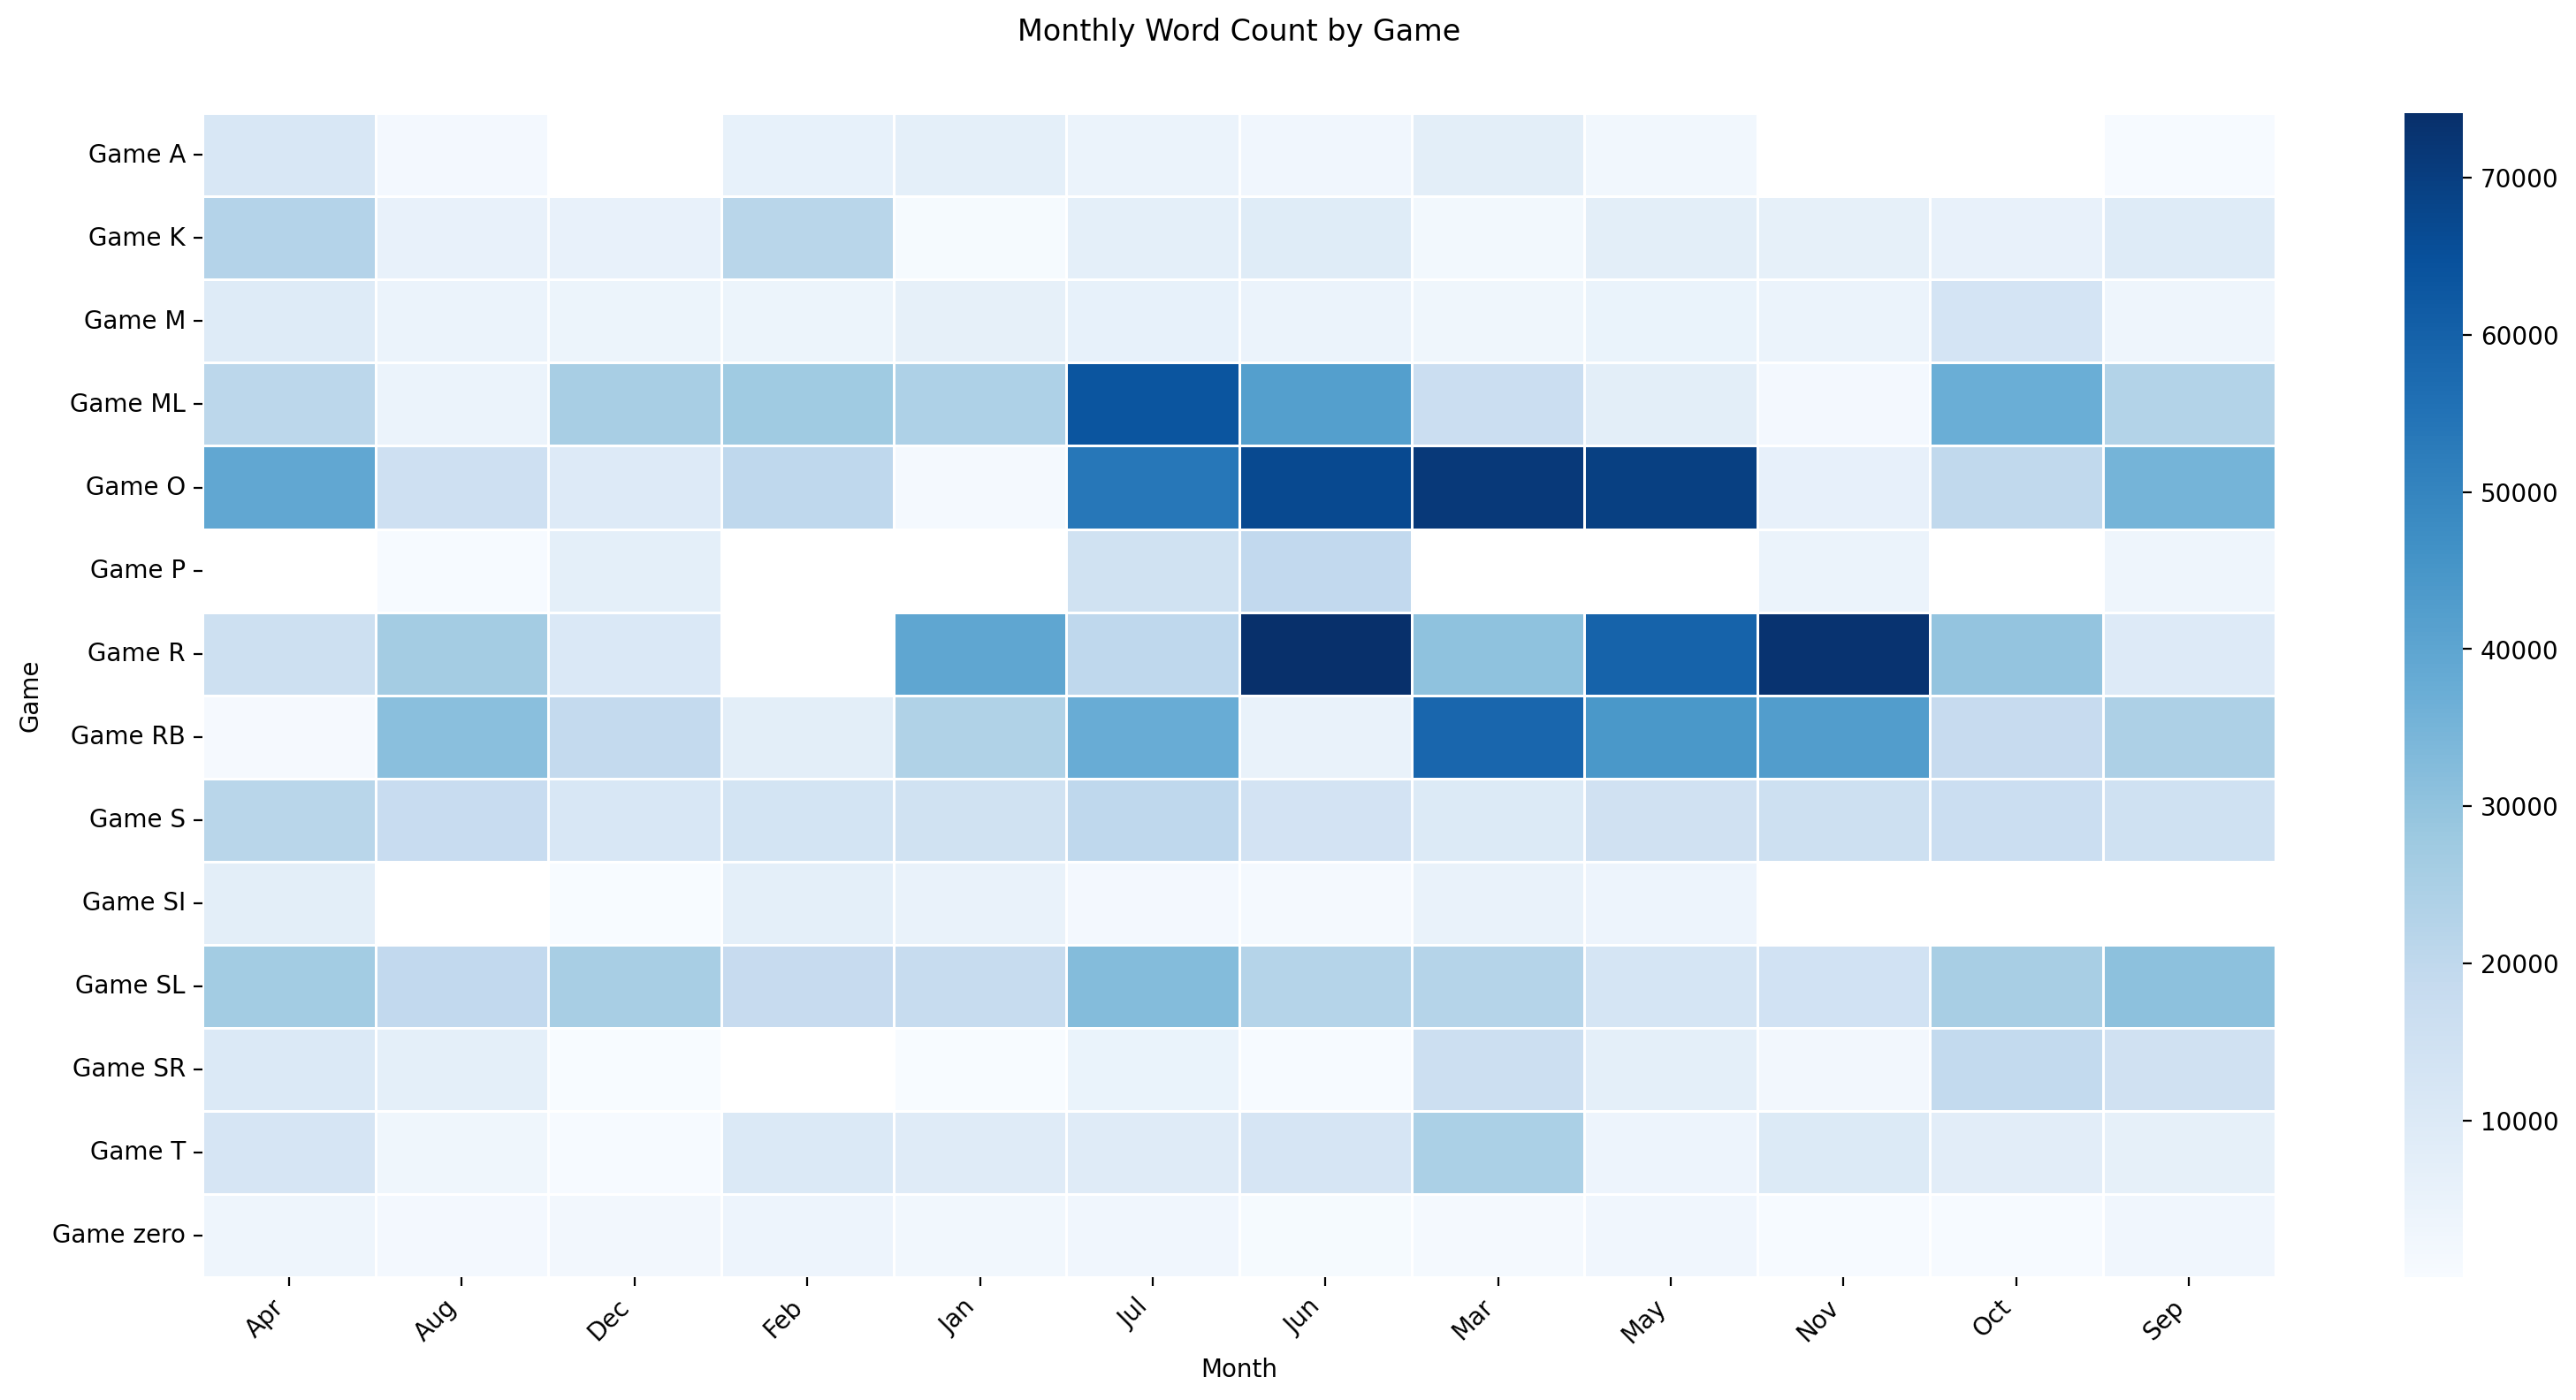

In [231]:
plt.figure(figsize=(16, 8), dpi=200)

sns.heatmap(
    heatmap_df,
    cmap="Blues",
    linewidths=0.5
)

plt.title("Monthly Word Count by Game", y=1.05)
plt.xlabel("Month")
plt.ylabel("Game")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The Heat map provides a clearer view of monthly word count trends by game compared to line chart. While line chart shows the overall trajectory, the heatmap makes patterns, peaks, and relative workloads immediately visible, expecially when volumes vary widely across games and months.

- ### Quearterly Word Count

In [232]:
quarterly_wc = (df.resample("Q", on="Date Rcvd")["Total WC"].sum())
quarterly_wc.index = quarterly_wc.index.to_period("Q")
quarterly_wc

/tmp/ipython-input-2927038516.py:1: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



,Total WC
Date Rcvd,
2025Q1,564062.0
2025Q2,721683.0
2025Q3,597160.0
2025Q4,498490.0


In [233]:
quarterly_due_wc = (
    df
    .resample("Q", on="Due Date")["Total WC"]
    .sum()
)
quarterly_due_wc.index = quarterly_due_wc.index.to_period("Q")
quarterly_due_wc.head()

/tmp/ipython-input-3068141379.py:3: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



,Total WC
Due Date,
2025Q1,490682.0
2025Q2,655106.0
2025Q3,750076.0
2025Q4,485531.0


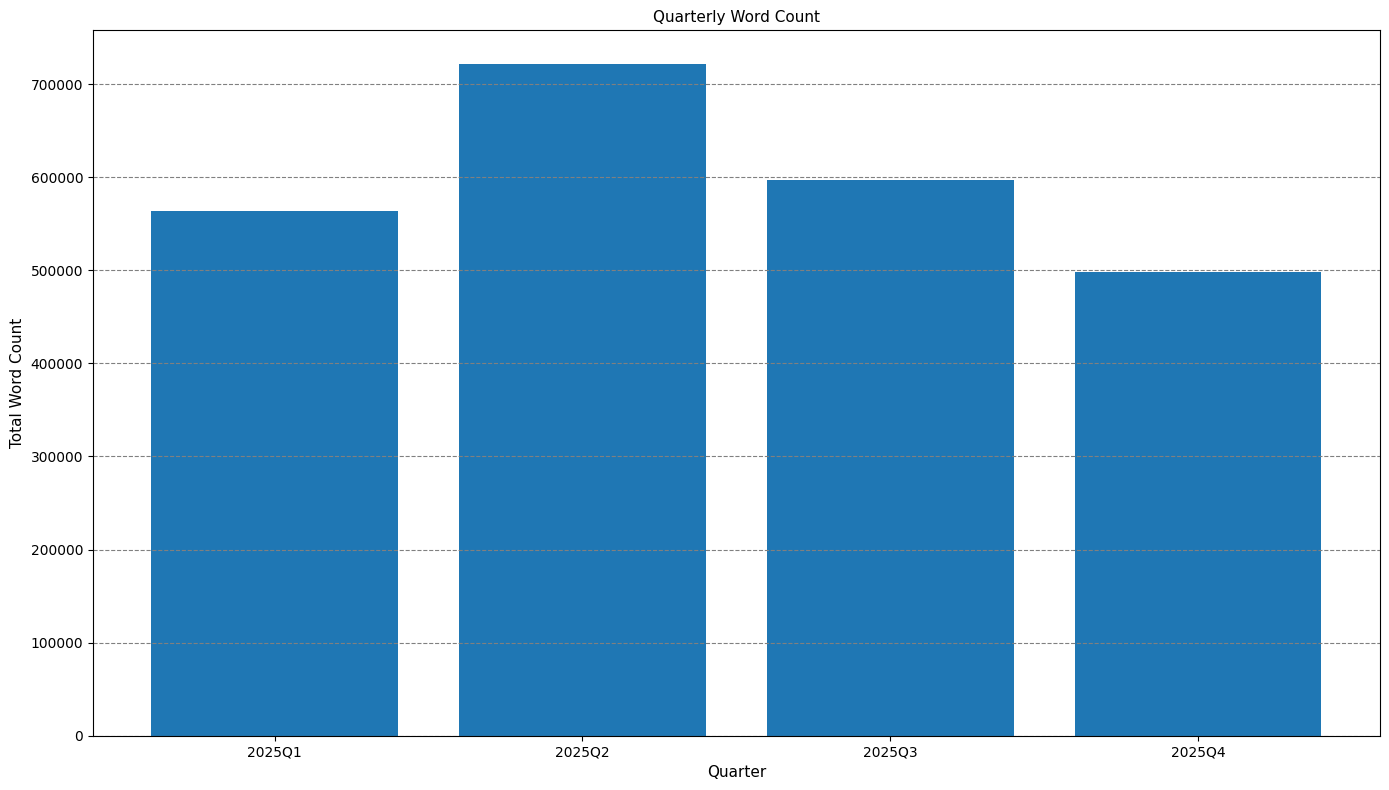

In [234]:
plt.figure(figsize=(14,8))
plt.bar(quarterly_wc.index. astype(str), quarterly_wc.values, label="Total WC")
'''
plt.bar(quarterly_due_wc.index.astype(str), quarterly_due_wc.values, label="Due WC")
'''

plt.grid(axis='y', which='major', color='grey', linestyle='--')

plt.xlabel("Quarter", fontsize = 11)
plt.ylabel('Total Word Count', fontsize = 11)
plt.title('Quarterly Word Count', fontsize= 11)
plt.tight_layout()
plt.show()

- ### Data by Linguists

In [235]:
# The Number of Linguists

print(f"Total number of in-house lingusits: {df["Assignee"].nunique()}")

Total number of in-house lingusits: 14


In [236]:
# The Number of Projects per each Linguist

linguists = df["Assignee"].value_counts()
linguists.head()

,count
Assignee,
Trans_01,1254
Trans_02,560
Edit_01,162
Trans_03,125
Trans_04,116


In [237]:
# Linguist Distribution - All Project Types: Trans, LQA, Review

fig = px.pie(labels=linguists.index, values=linguists.values, title="Linguist Distribution", names=linguists.index, hole=0.4)
fig.update_traces(textposition='outside', textinfo="percent+label")
fig.show()

In [238]:
# Linguist Distribution - Translation

trans_linguists = (df[df["Request Type"] == "Trans"]["Assignee"].value_counts())
trans_linguists

,count
Assignee,
Trans_01,1249
Trans_02,559
Trans_03,125
Trans_04,116
Vendor_M,88
Vendor_E,34


In [239]:
fig = px.pie(labels=trans_linguists.index, values=trans_linguists.values, title="Linguist Distribution", names=trans_linguists.index, hole=0.4)
fig.update_traces(textposition='outside', textinfo="percent+label")
fig.show()

**NOTE**: It appears that Trans_01 handled a disproportionately large share of the workload. It is worth notihg that the in-house translation team redistributes tasks based on overall workload.

- ### Total WC in 2025

In [240]:
total_wc = df['Total WC'].sum()
print(f"Total Word Count in 2025: {total_wc}")

Total Word Count in 2025: 2381395.0


- ### Word Count by In-house vs LSPs (Vendors)

In [241]:
vendor_wc = (
    df.groupby("Assignee")["Total WC"].sum()
    .loc[["Vendor_M", "Vendor_E"]]
    .sum()
)
print(f"Wordcount handled by Vendors: {vendor_wc}")

Wordcount handled by Vendors: 628613.0


In [242]:
wc_distribut = pd.DataFrame({"Work Type": ["Outsourced", "In-House"], "Total WC": [vendor_wc, total_wc]})
wc_distribut

,Work Type,Total WC
0,Outsourced,628613.0
1,In-House,2381395.0


In [243]:
fig = px.pie(wc_distribut, names="Work Type", values="Total WC", title="Trans Distribution", hole=0.4)
fig.update_traces(textposition='inside', textinfo="percent+label")
fig.show()

**NOTE**: This distribution reflects workflow scope rather than an absolute share of workload. The in-house team supports KO-EN localization only, while vendors handles KO-EN as well as additional target langauges.

- ### Number of Projects vs. Total WC vs. Average WC per Project by Games

In [244]:
wc_by_game = df.groupby('Game')['Total WC'].sum()
wc_by_game.sort_values(ascending=False)

,Total WC
Game,
Game O,409137.0
Game R,389434.0
Game RB,314109.0
Game ML,294315.0
Game SL,269749.0
Game S,185664.0
Game T,110995.0
Game K,103613.0
Game SR,83212.0


In [245]:
trans_project = (df[df["Request Type"] == "Trans"].groupby("Game").size().rename("Trans_Project"))
game_metrics = trans_project.to_frame().join(wc_by_game)
game_metrics["Avg_WC_per_Project"] = game_metrics["Total WC"] / game_metrics["Trans_Project"]
game_metrics.head()

,Trans_Project,Total WC,Avg_WC_per_Project
Game,,,
Game A,117,44114.0,377.042735
Game K,163,103613.0,635.662577
Game M,231,68972.0,298.580087
Game ML,85,294315.0,3462.529412
Game O,97,409137.0,4217.907216


In [246]:
scatter = px.scatter(game_metrics.reset_index(),
                     x = "Trans_Project",
                     y="Total WC",
                     size="Avg_WC_per_Project",
                     color="Game",
                     hover_name="Game",
                     size_max=60,
                     labels={
                         "Trans_Project": "Number of Trans Projects",
                         "Total WC": "Total Word Count",
                         "Avg_WC_per_Project": "Avg WC per Project"
                     },
                     title = "Translation Project Volume vs Word Count by Game"
                     )
scatter.update_traces(hovertemplate="<b>%{hovertext}</b><br>" +
    "Trans Projects: %{x}<br>" +
    "Total WC: %{y:,}<br>" +
    "Avg WC / Project: %{marker.size:,.0f}<extra></extra>")
scatter.show()

**Interesting finding**: Titles with a high average word count per translation request tend to be associated with earlier lifecylce stages, where localization work is delivered in larger, bundled requests rather than frequent incremental updates (e.g., Game O, Game R, Game ML)

- ### Monthly and Yearly Translation Workload

In [247]:
inhouse_trans = df[(df["Request Type"] == "Trans") & (df["Assignee"].str.startswith("Trans_", na=False))]
inhouse_trans.head()

,Game,Request Type,Assignee,Total WC,Languages,Date Rcvd,Due Date,Status
2,Game S,Trans,Trans_01,956.0,MLT only,2025-12-18,2025-01-02,Delivered
3,Game A,Trans,Trans_01,220.0,MLT only,2025-01-02,2025-01-03,Delivered
4,Game A,Trans,Trans_01,85.0,MLT only,2025-01-02,2025-01-03,Delivered
5,Game SI,Trans,Trans_02,100.0,EN only,2025-12-19,2025-01-03,Delivered
7,Game S,Trans,Trans_01,356.0,EN only,2025-01-02,2025-01-03,Delivered


In [248]:
monthly_inhouse_wc = (
    inhouse_trans
    .groupby(inhouse_trans["Date Rcvd"].dt.to_period("M"))["Total WC"]
    .sum()
    .reset_index()
)

monthly_inhouse_wc["Month"] = monthly_inhouse_wc["Date Rcvd"].dt.to_timestamp()
monthly_inhouse_wc.head()

,Date Rcvd,Total WC,Month
0,2025-01,86101.0,2025-01-01
1,2025-02,130715.0,2025-02-01
2,2025-03,201844.0,2025-03-01
3,2025-04,137837.0,2025-04-01
4,2025-05,140796.0,2025-05-01


In [249]:
num_translators = (inhouse_trans["Assignee"].nunique())
print(f"In-house localization team has {num_translators} translators")

In-house localization team has 4 translators


In [250]:
# Monthly Average WC per Translator

monthly_inhouse_wc["Avg WC per Translator"] = (monthly_inhouse_wc["Total WC"] / num_translators)

monthly_inhouse_wc

,Date Rcvd,Total WC,Month,Avg WC per Translator
0,2025-01,86101.0,2025-01-01,21525.25
1,2025-02,130715.0,2025-02-01,32678.75
2,2025-03,201844.0,2025-03-01,50461.00
3,2025-04,137837.0,2025-04-01,34459.25
4,2025-05,140796.0,2025-05-01,35199.00
5,2025-06,127030.0,2025-06-01,31757.50
6,2025-07,231947.0,2025-07-01,57986.75
7,2025-08,111263.0,2025-08-01,27815.75
8,2025-09,178072.0,2025-09-01,44518.00
9,2025-10,191797.0,2025-10-01,47949.25


In [251]:
# Yearly Average WC per In-House Translator, excluding Vendor's WC

total_2025_wc = inhouse_trans["Total WC"].sum()

avg_yearly_wc_per_translator = total_2025_wc / num_translators

print(f"Average WC per Translator over the year of 2025: {avg_yearly_wc_per_translator:,.0f}")

Average WC per Translator over the year of 2025: 434,887


In [252]:
import plotly.graph_objects as go

fig = go.Figure()

# Monthly average WC (left y-axis)
fig.add_trace(
    go.Scatter(
        x=monthly_inhouse_wc["Month"],
        y=monthly_inhouse_wc["Avg WC per Translator"],
        mode="lines+markers",
        name="Monthly Avg WC per Translator",
        yaxis="y1"
    )
)

# Yearly average WC (right y-axis)
fig.add_trace(
    go.Scatter(
        x=monthly_inhouse_wc["Month"],
        y=[avg_yearly_wc_per_translator] * len(monthly_inhouse_wc),
        mode="lines",
        name="Yearly Avg WC per Translator",
        line=dict(dash="dash"),
        yaxis="y2"
    )
)

fig.update_layout(
    title="Monthly vs Yearly Average Translation Word Count per In-house Translator (2025)",
    xaxis=dict(title="Month"),

    yaxis=dict(
        title="Monthly Avg WC per Translator",
        tickformat=",",
        titlefont=dict(color="#1f77b4")
    ),

    yaxis2=dict(
        title="Yearly Avg WC per Translator",
        overlaying="y",
        side="right",
        tickformat=",",
        showgrid=False,
        titlefont=dict(color="#ff7f0e")
    ),

   legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
)
)

fig.show()

The monthly average translation volume per in-house translator ranged from around 25k to 58k words in 2025. This variation reflects differences in content complexity, game lifecycle stage, and non-translation responsibilities typical of in-house localization teams.